In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression #gotta start somewhere
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline # I remember the idea of pipelines from datacamp.com and I intend to always
                                           # use pipelines with ML
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['figure.dpi'] = 300

In [2]:
df = pd.read_csv('train.csv',index_col='PassengerId')
sex_dict = {'male':0,
           'female':1}
df['Is_female']=df['Sex'].map(sex_dict)
df['Pclass']=df['Pclass']
df['has_Cabin']=df['Cabin'].notnull().astype('int')


#.astype('category') We will use this later for ML but will leave as integers for EDA for now.
# will do the imputing of the missing embarked location using a categorical imputer like KNNImputer

df.drop(columns=['Name','Ticket','Sex','Cabin'],inplace=True)

# In retrospect, I should not do this (The code below) because the mean age of the training set would be influenced 
# by the test set and vice versa.
# I will do the imputing in the ML pipeline instead - after splitting the data

#mean_age = df['Age'].loc[df['Age'].notnull()].mean()
#df.loc[df['Age'].isnull(),'Age']=mean_age
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Age        714 non-null    float64
 3   SibSp      891 non-null    int64  
 4   Parch      891 non-null    int64  
 5   Fare       891 non-null    float64
 6   Embarked   889 non-null    object 
 7   Is_female  891 non-null    int64  
 8   has_Cabin  891 non-null    int32  
dtypes: float64(2), int32(1), int64(5), object(1)
memory usage: 66.1+ KB


In [3]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Is_female,has_Cabin
PassengerId,,,,,,,,,
1,0,3,22.0,1,0,7.2500,S,0,0
2,1,1,38.0,1,0,71.2833,C,1,1
3,1,3,26.0,0,0,7.9250,S,1,0
4,1,1,35.0,1,0,53.1000,S,1,1
5,0,3,35.0,0,0,8.0500,S,0,0


In [4]:
# Exploring relationships between survived and gender
df[['Is_female','Survived']].groupby('Is_female').mean()

,Survived
Is_female,
0,0.188908
1,0.742038


In [5]:
df[['has_Cabin','Survived']].groupby('has_Cabin').mean()

,Survived
has_Cabin,
0,0.299854
1,0.666667


The data frame above shows that almost 75% of females survived while only 19% of males survived. Fairly strong correlation right there. Also a strong correlation between having a cabin and surviving.

In [6]:
df_child = df.loc[df['Age']<18].Survived
print('Survival chance for minors (<18) '+ str(round(df_child.mean(),2)))

df_yadult = df.loc[(df['Age']>=18) & (df['Age']<30)].Survived
print('Survival chance for young adults (18 - 30) '+ str(round(df_yadult.mean(),2)))

df_oadult = df.loc[(df['Age']>=30) & (df['Age']<=60)].Survived
print('Survival chance for adults (30 - 60) '+ str(round(df_oadult.mean(),2)))

df_elder = df.loc[df['Age']>60].Survived
print('Survival chance for the elderly (>60) '+ str(round(df_elder.mean(),2)))


Survival chance for minors (<18) 0.54
Survival chance for young adults (18 - 30) 0.35
Survival chance for adults (30 - 60) 0.42
Survival chance for the elderly (>60) 0.23


Decent chance of survival for the kids, which diminishes with age. The elderly survivability is seemingly particularly low. I think if we further subdivide by age, we will see some stronger effect of age on survivability. So plotting Survivability by Age in something akin to a histogram is the next thing to do.

In [7]:
df_age = df[['Age','Survived']].groupby('Age').mean()
df_age_cts = df[['Age','Survived']].groupby('Age').count()
# This is not quite what I want to do, I want to set a series of age ranges and compute the average survivability within that 
# range. I will try writing a function which will loop through the dataframe and collect rows within the range I want to use.

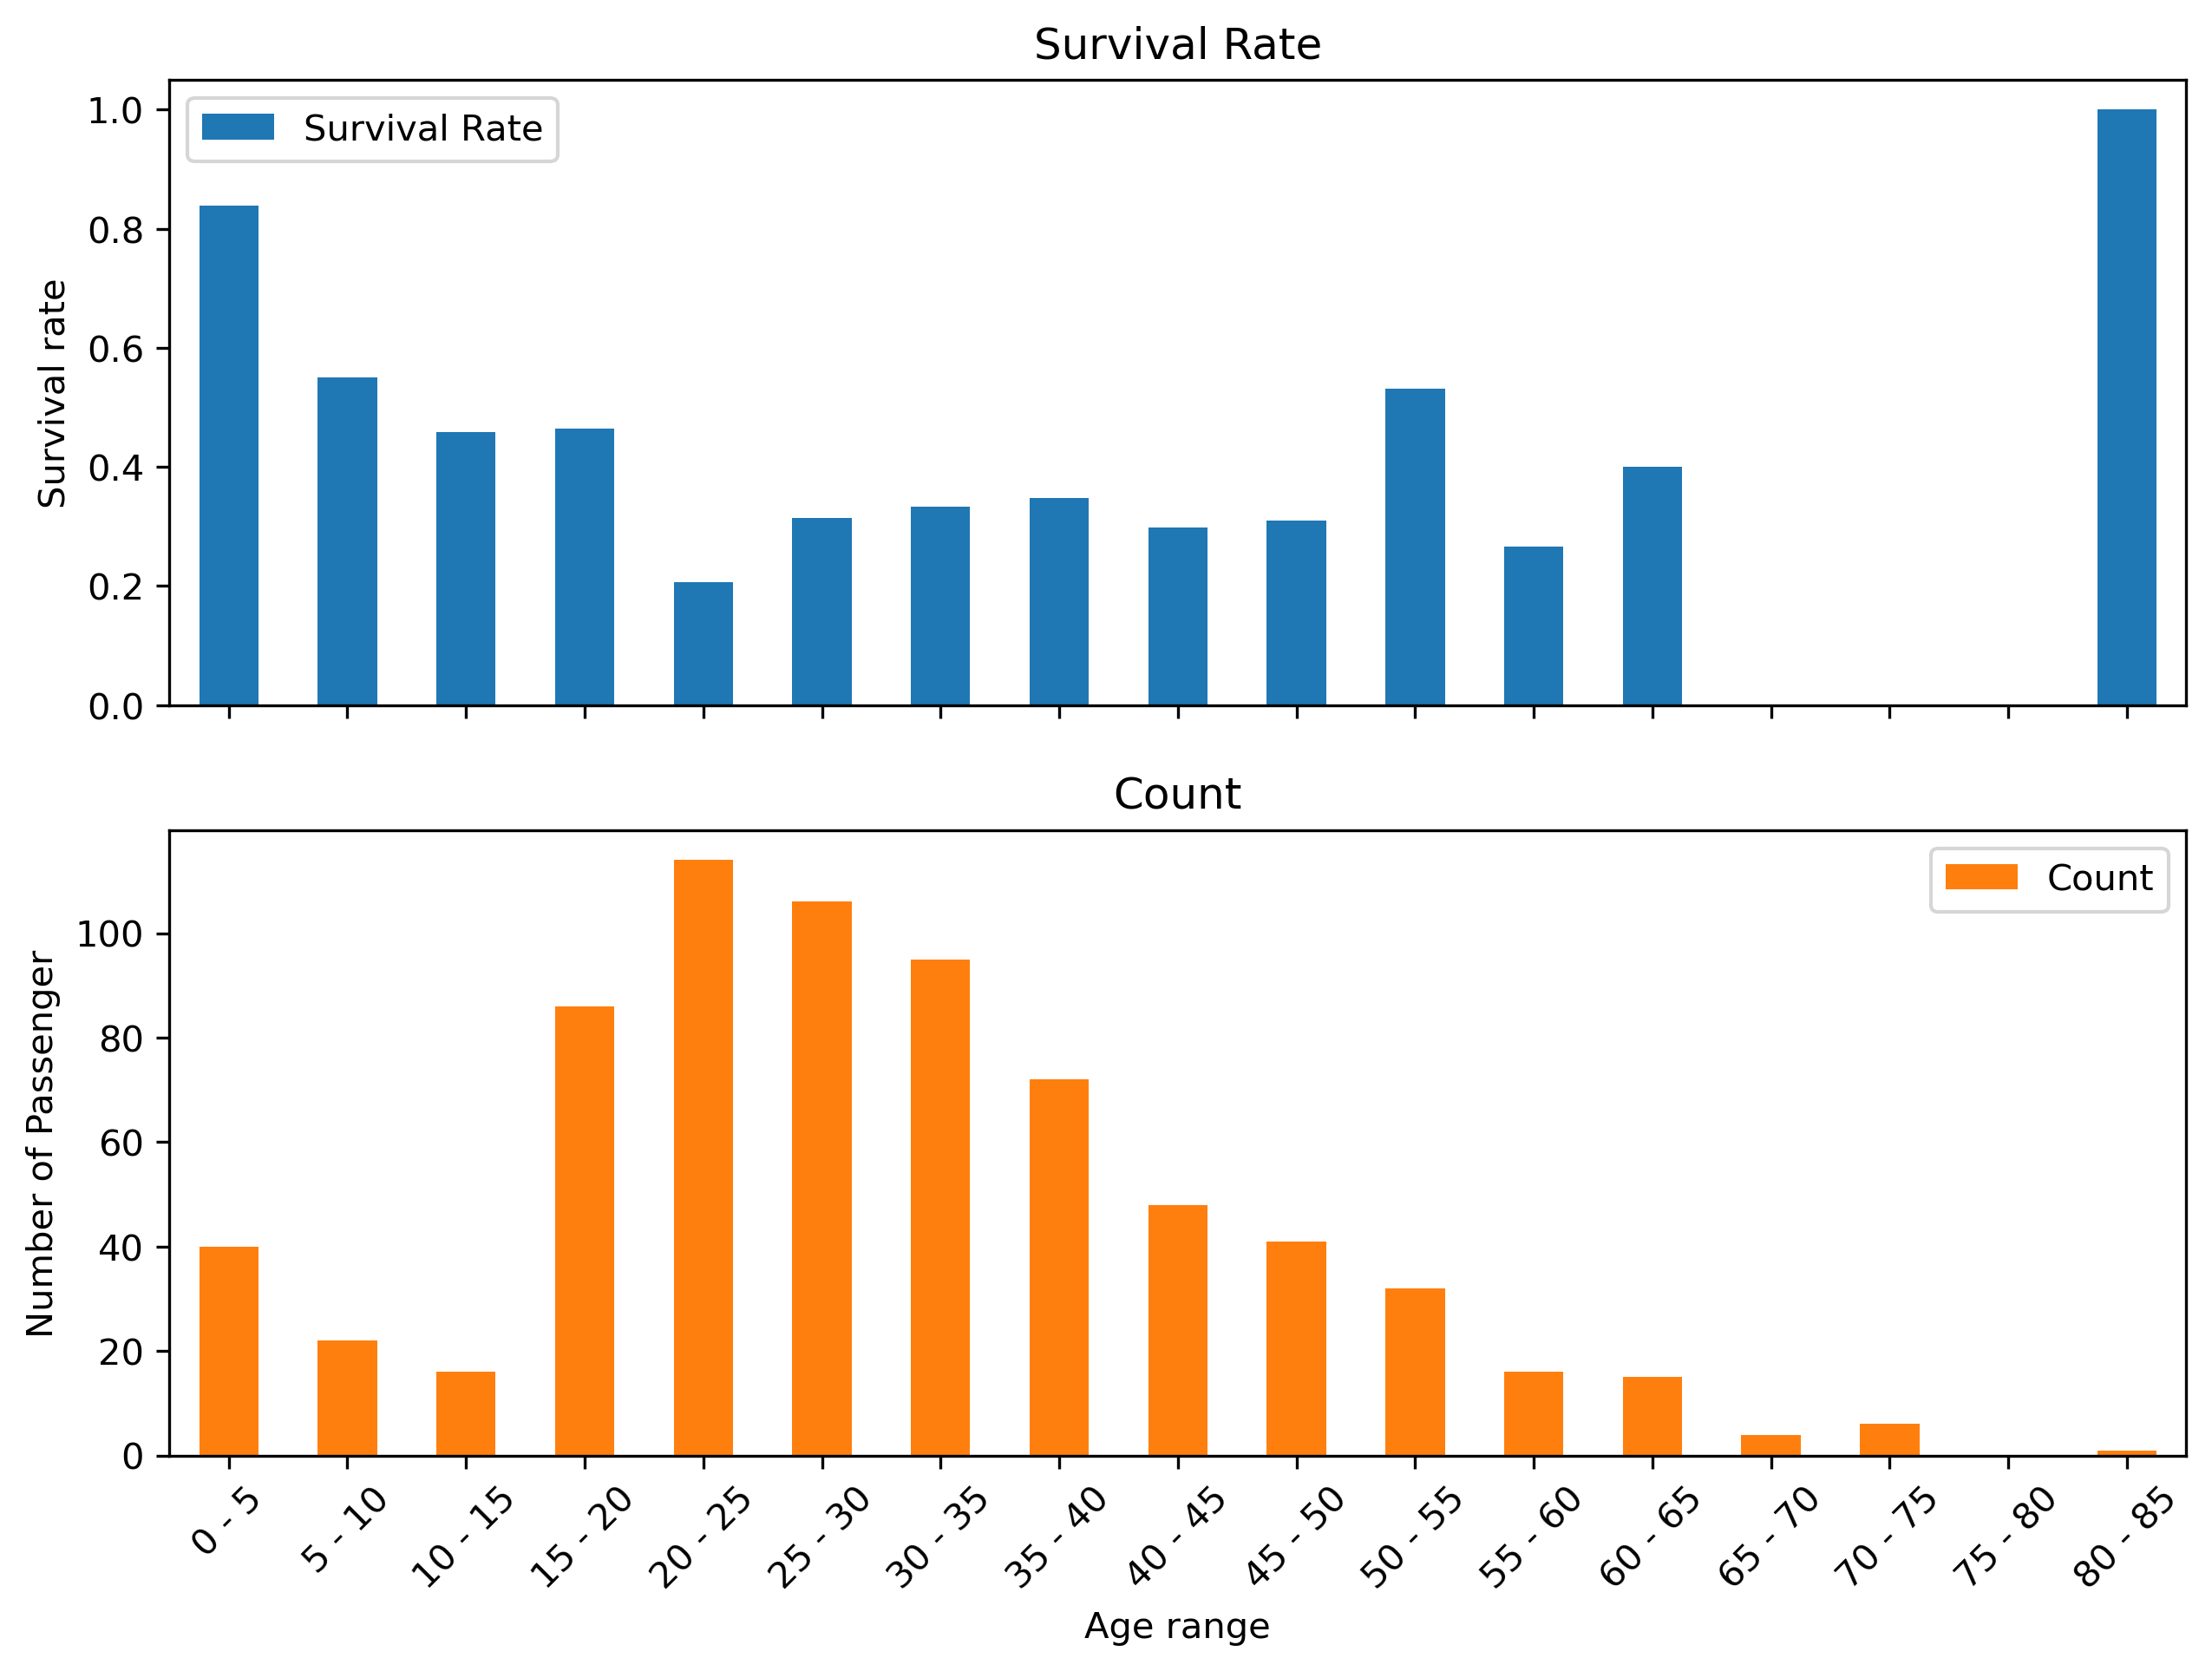

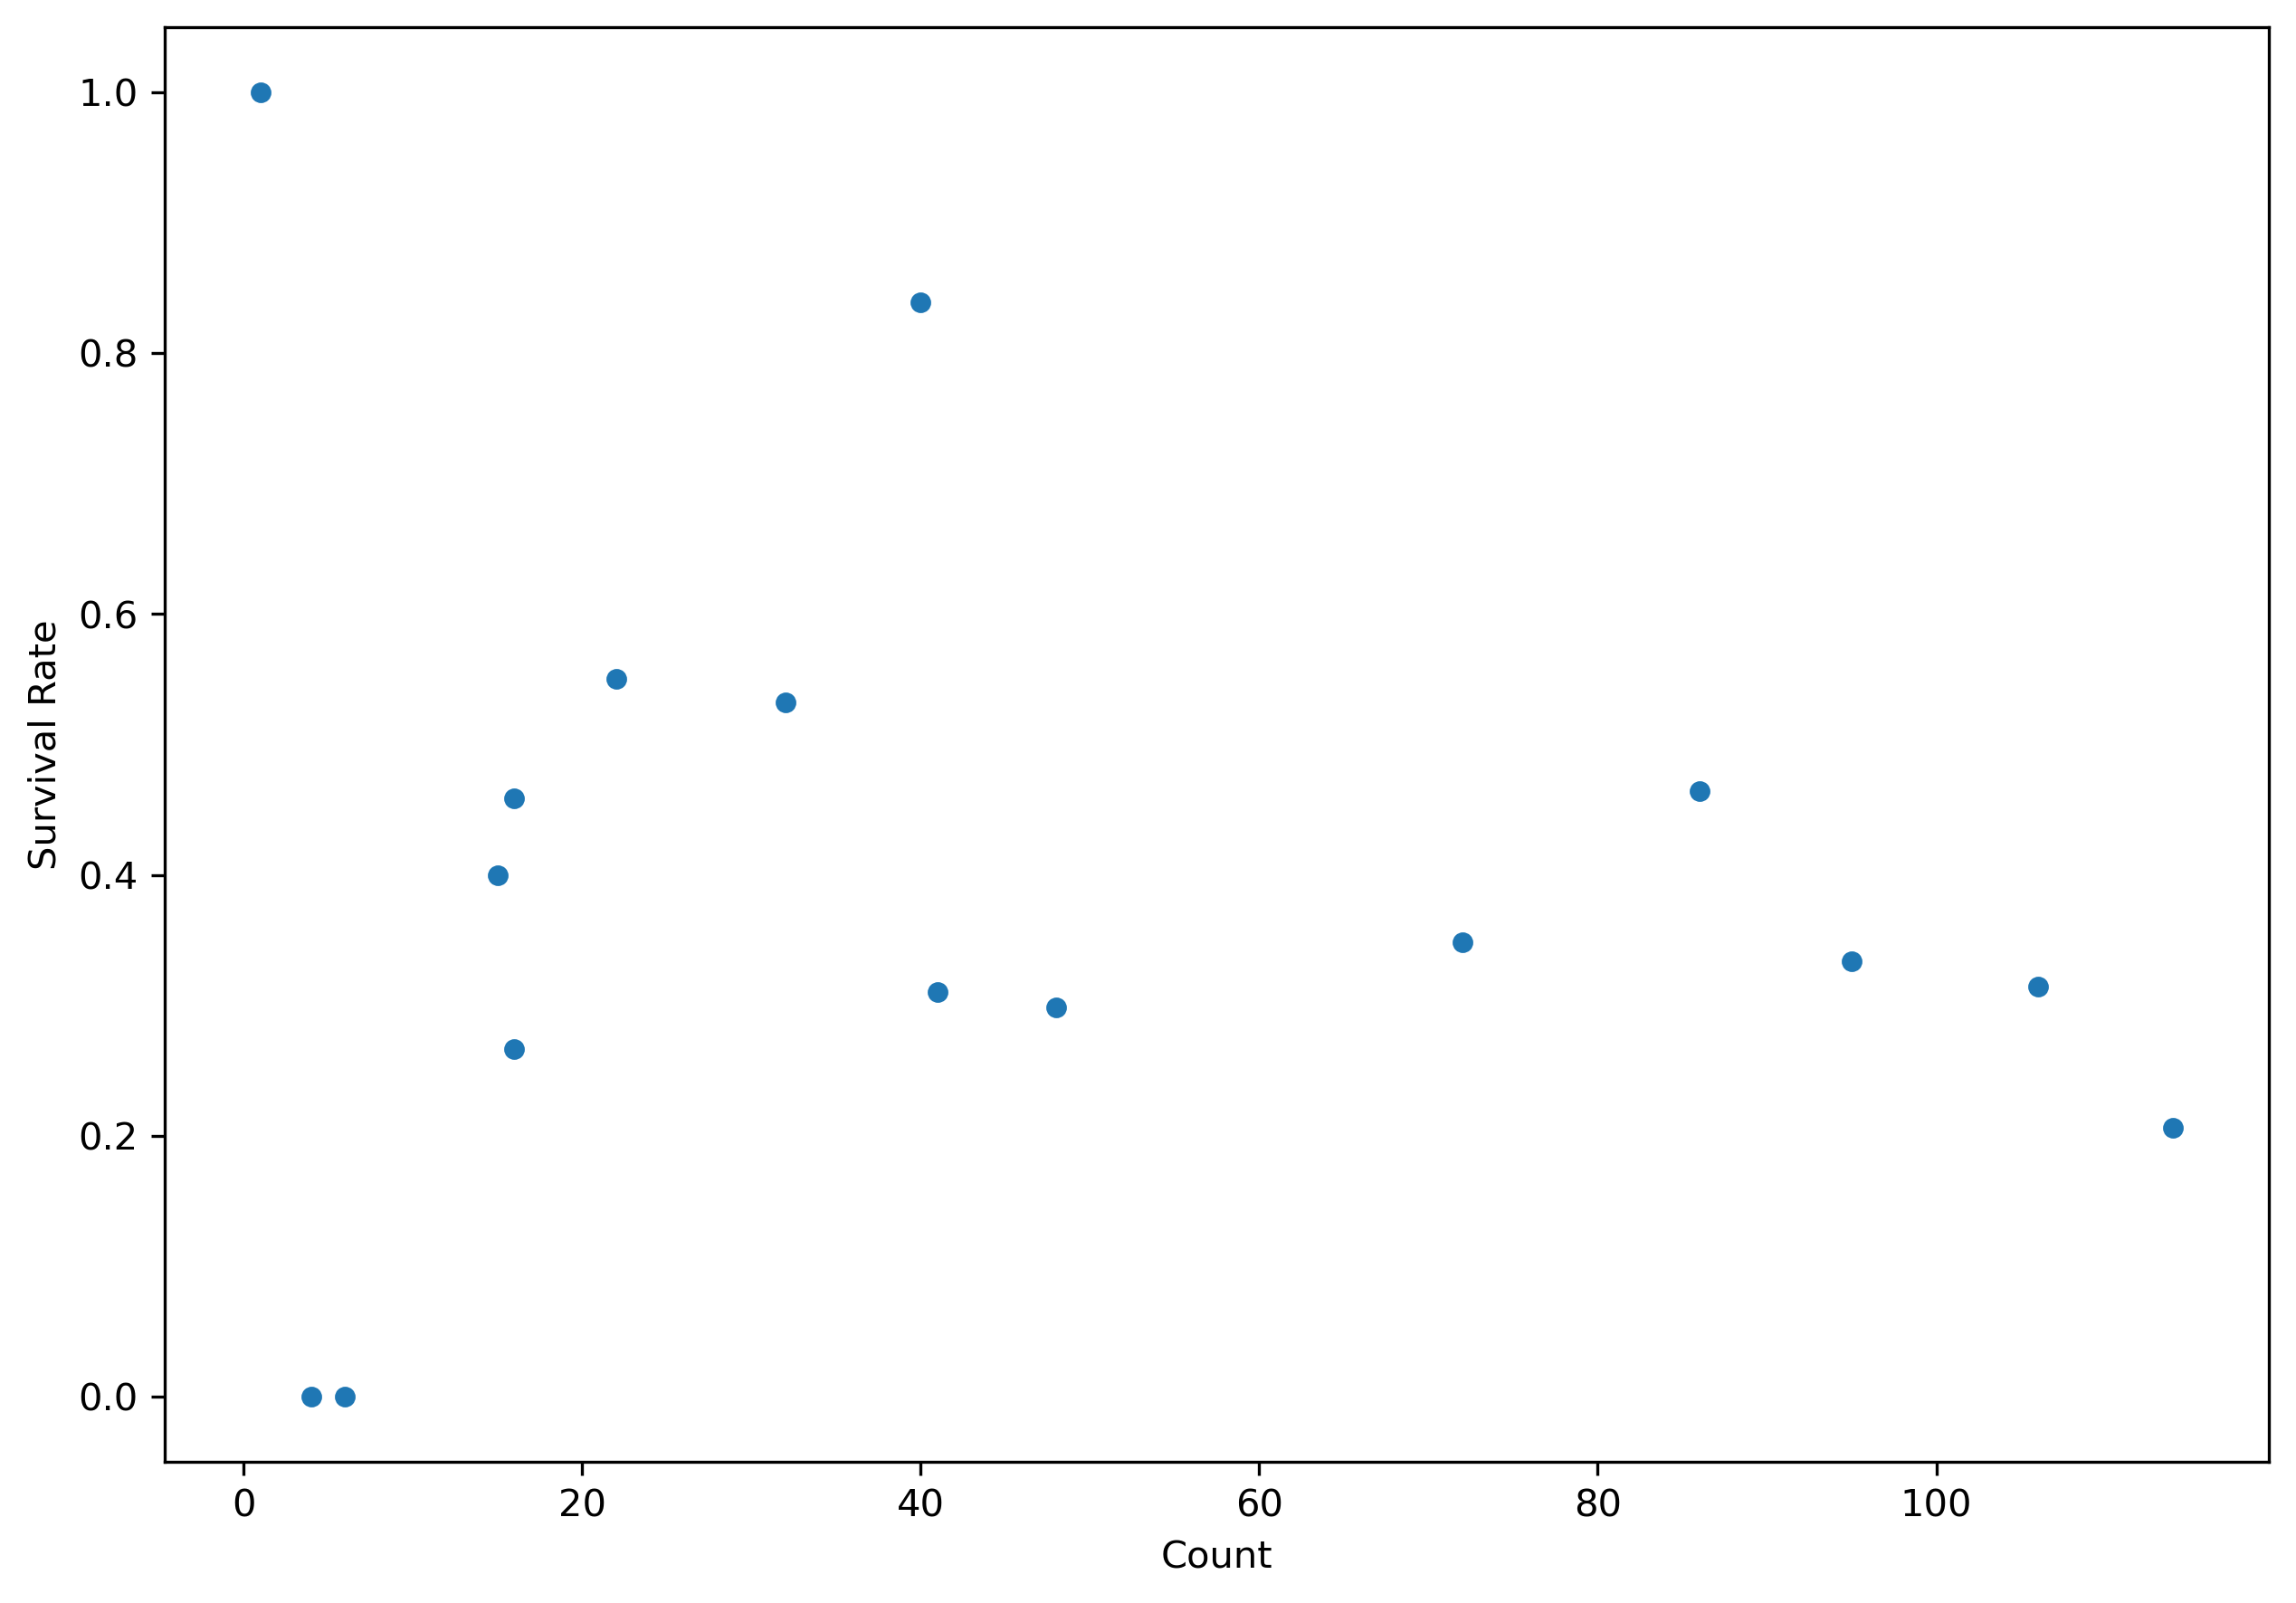

In [8]:
dict_age_range = {}
age_wind=5
for age in np.arange(0,85,age_wind):
    a_range = ('%d - %d' % (age,age+age_wind))
    surv_age = df_age['Survived'].loc[age:age+age_wind-1E-4].mean() # We are subtracting 1E-4 because that prevents overlap in the windows.
    surv_counts = df_age_cts['Survived'].loc[age:age+age_wind-1E-4].sum()
    dict_age_range.update({a_range: [surv_age,surv_counts]})

# I would assume there is a better way of doing this, however I was having trouble finding a function to do this so I wrote
# a for loop to do it.
    
df_age_plt = pd.DataFrame.from_dict(dict_age_range).transpose()
df_age_plt.columns=(['Survival Rate','Count'])

axes = df_age_plt.plot(subplots=True, kind='bar')
axes[0].set_ylabel('Survival rate')
axes[1].set_ylabel('Number of Passenger')
plt.xlabel('Age range')
plt.tick_params(axis='x',labelrotation=45)

plt.figure
df_age_plt.plot(x='Count',y='Survival Rate',kind='scatter')

So it is pretty clear that survivability for middle aged individuals is quite low relative to childre. Looking at the number of passengers per range is pretty important because even though surviviabaility for the 80-85 range is high it is only because there was one person. There is also inherently no trend between the survival rate and the number of passengers in that group, i.e. something like a quota.

But what about the embarked location? Does that influence things? I originally ignored it but I think after working in this notebook for a while, I am feeling more confident to incorporate it and I think it could be the not irrelevant.

In [9]:
print('Survived Dataframe')
print(df[['Embarked','Survived']].groupby('Embarked').mean())
print('\n Counts Dataframe')
print(df[['Embarked','Survived']].groupby('Embarked').count())

# Interestingly, It looks like there might be a correlation here with the embarked location and survivability. Perhaps, higher
# class individuals were more likely to embark from a certain location.

Survived Dataframe
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957

 Counts Dataframe
          Survived
Embarked          
C              168
Q               77
S              644


Text(0.5, 0, 'Passenger class')

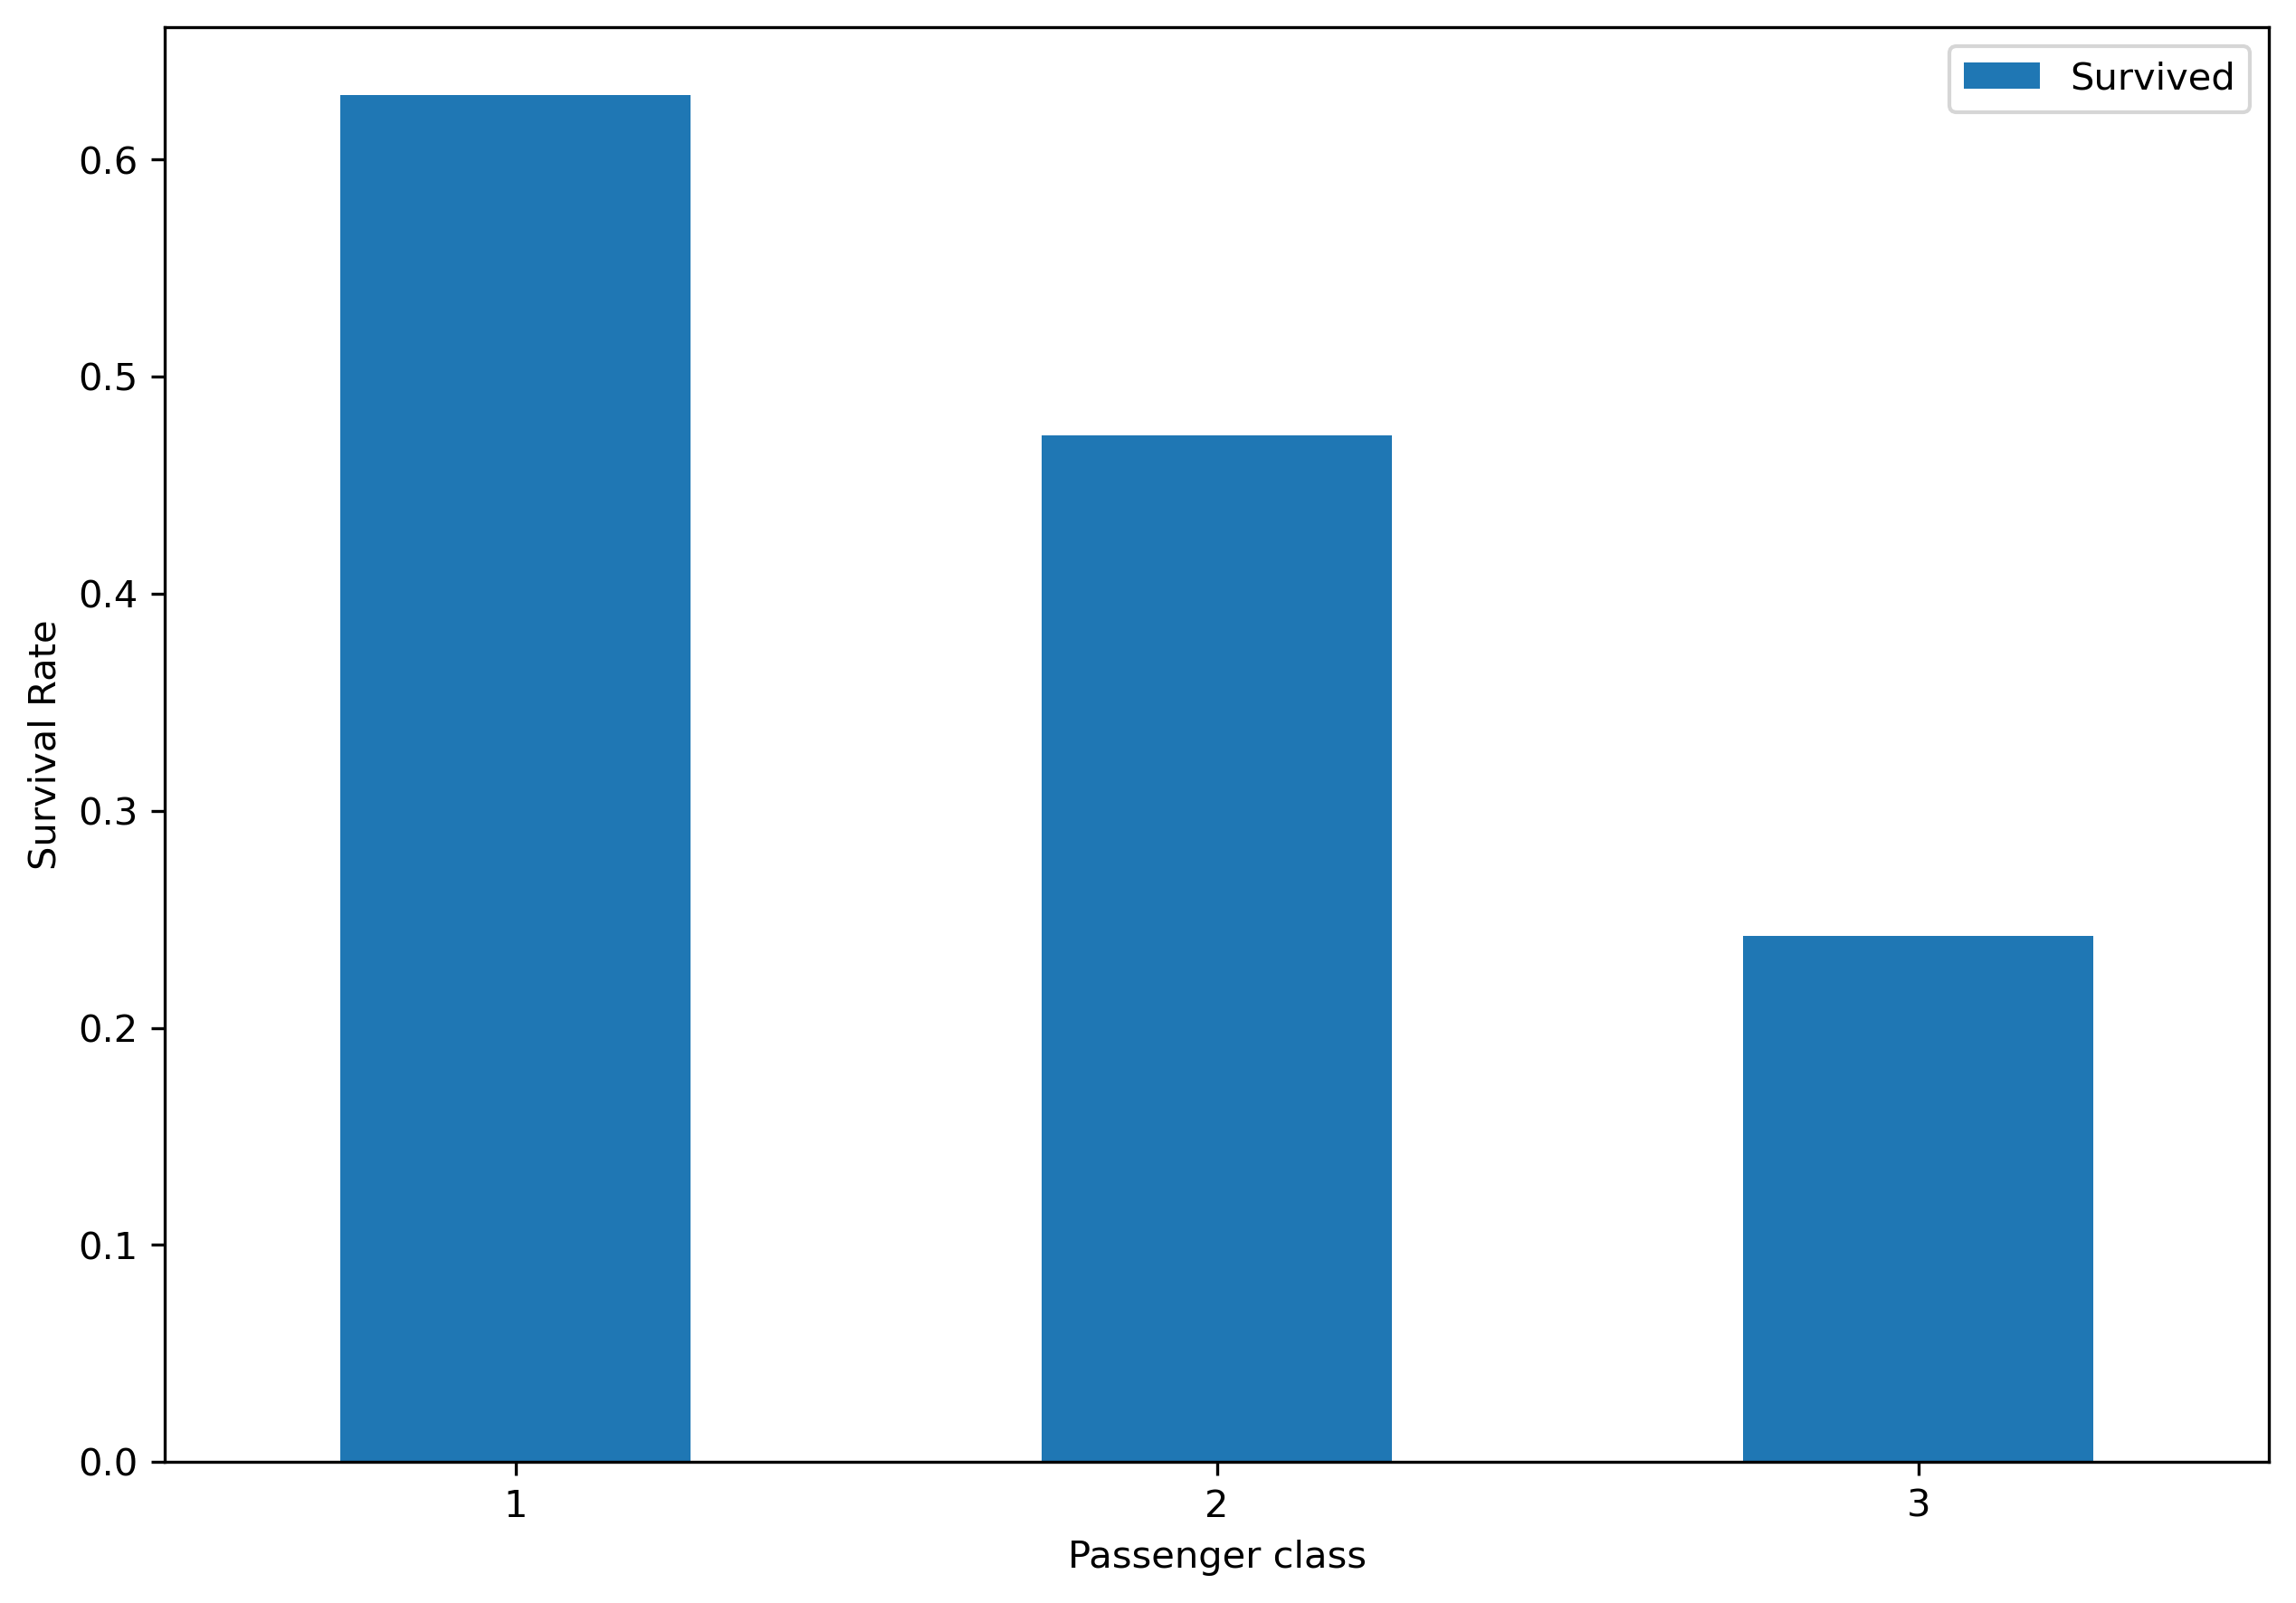

In [10]:
df[['Pclass','Survived']].groupby('Pclass').mean().plot(kind='bar')
plt.tick_params(axis='x',labelrotation=0) # just to set back to normal after the previous plot
plt.ylabel('Survival Rate')
plt.xlabel('Passenger class')

Pretty clear trend right there. Higher class passengers were likely given priority for lifeboats.

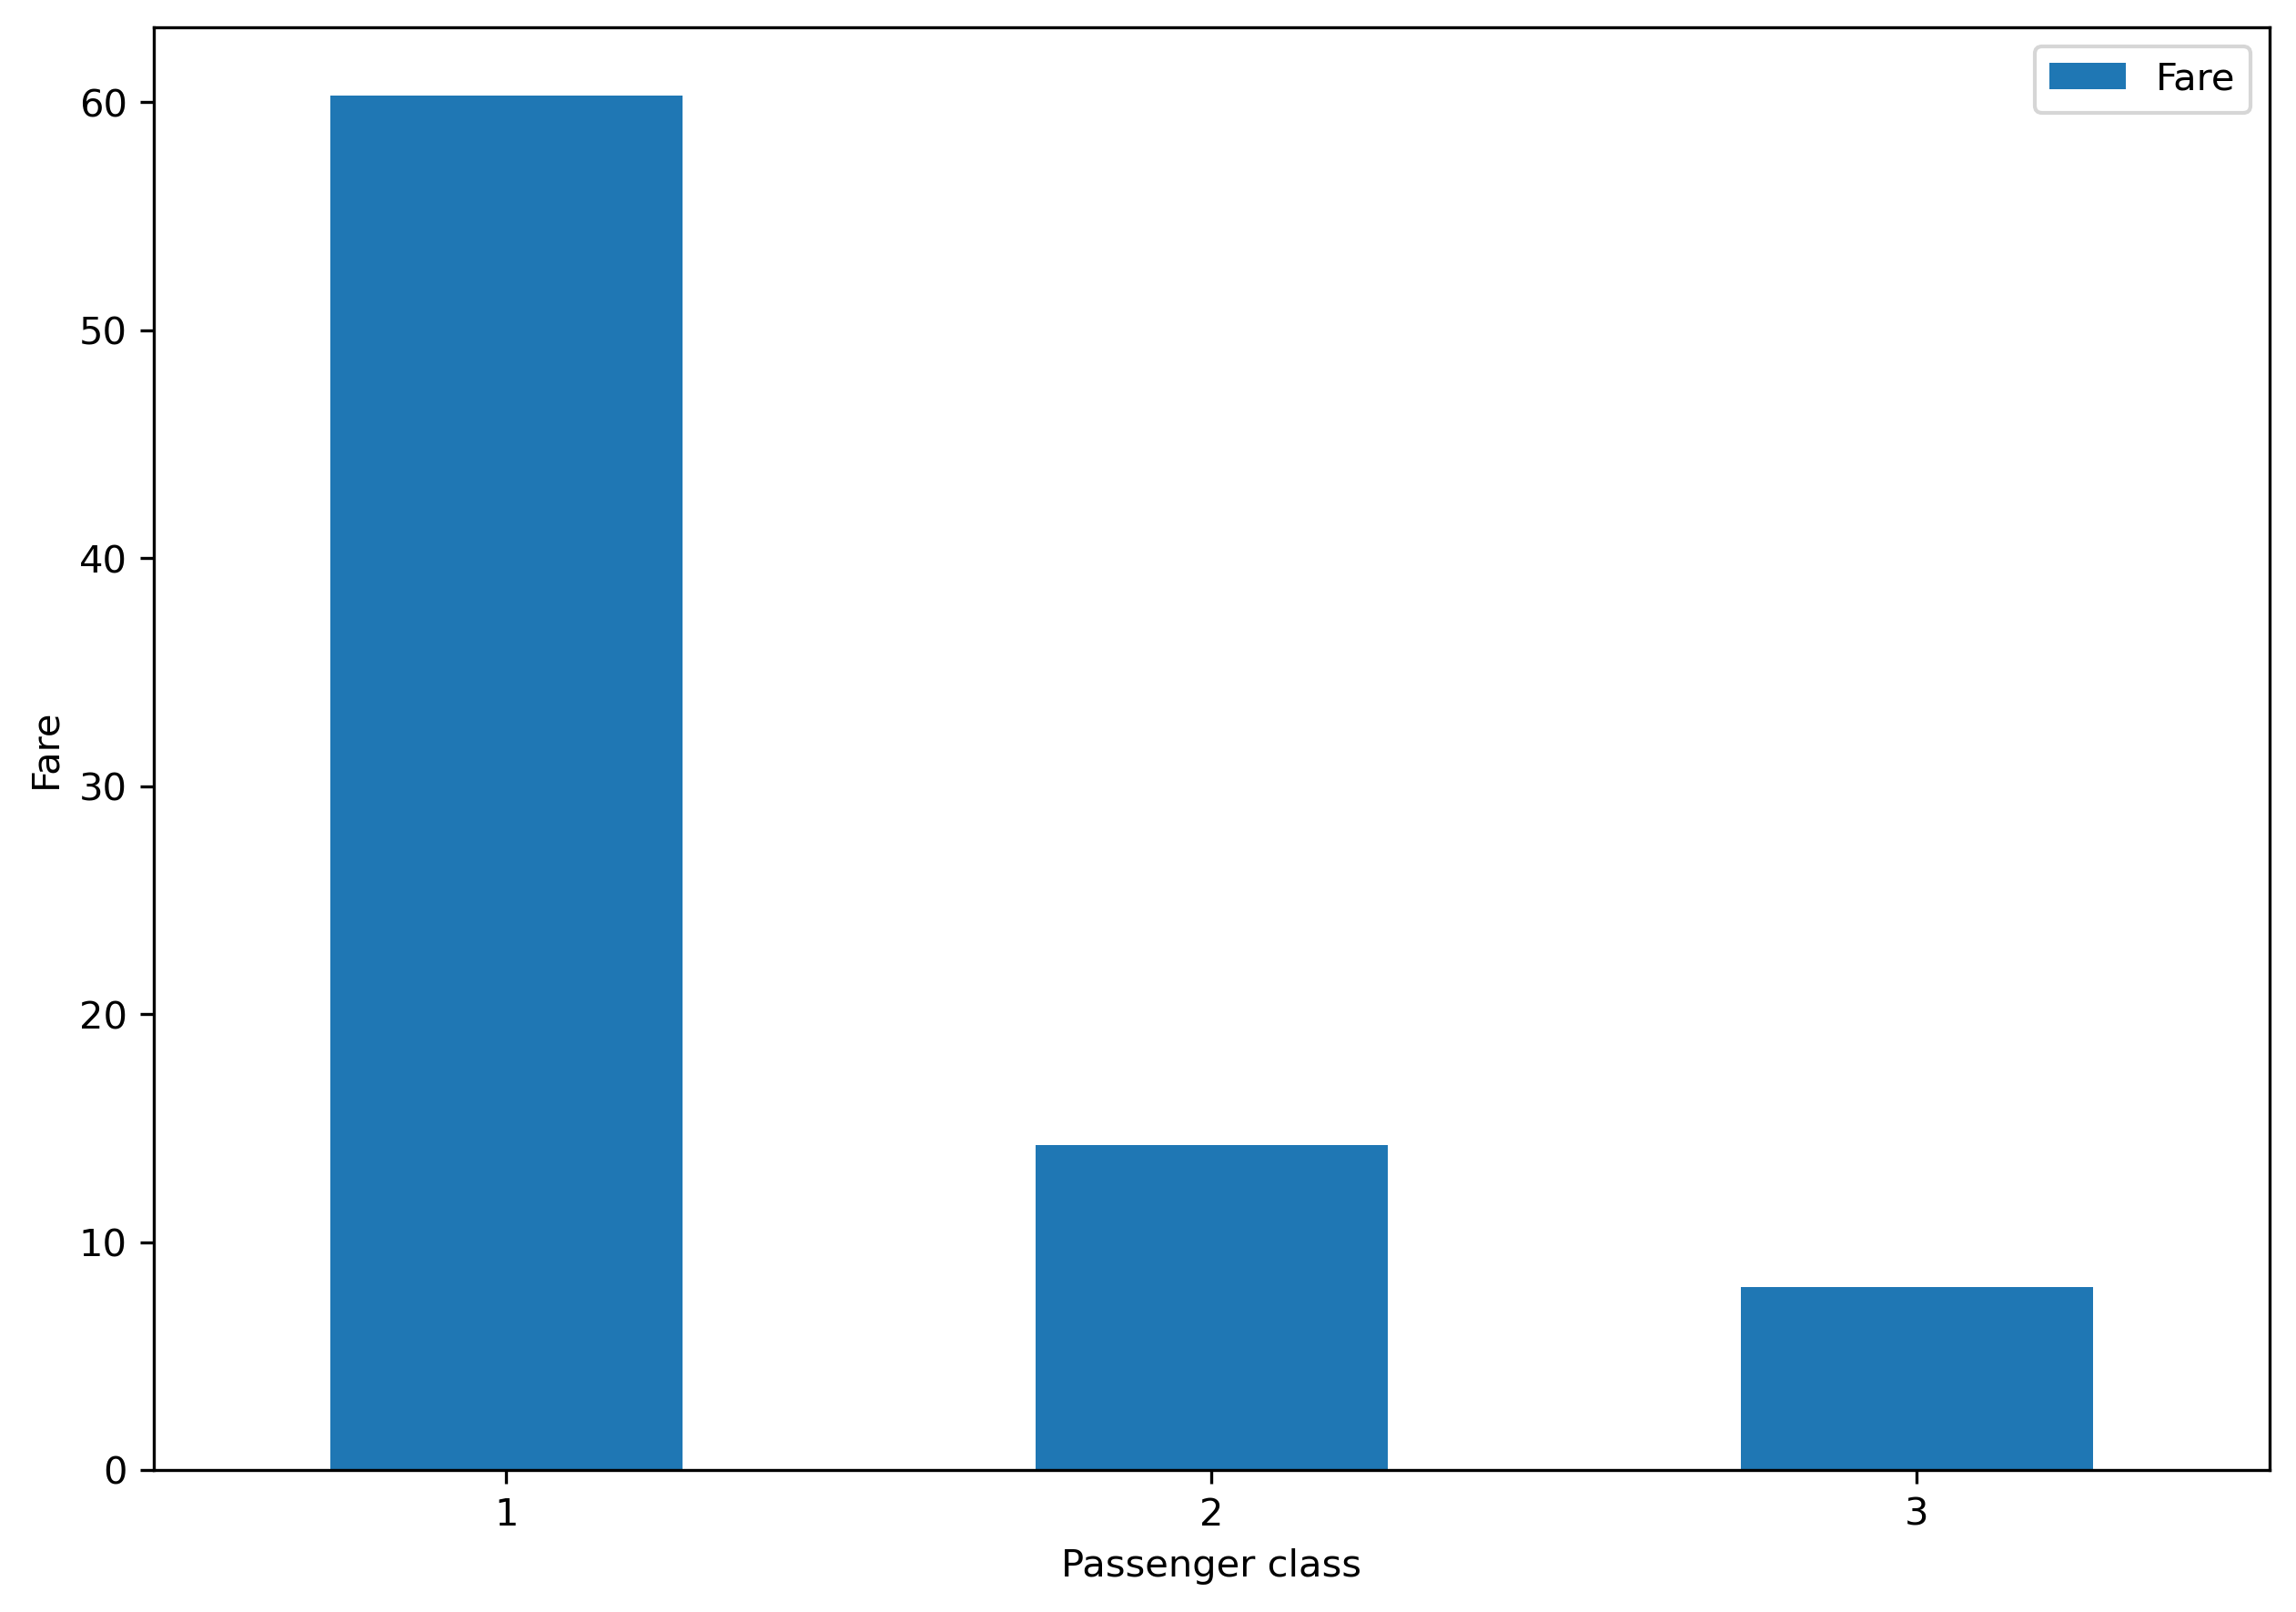

In [11]:
df[['Pclass','Fare']].groupby('Pclass').median().plot(kind='bar') #median makes more sense to use for this plot.
plt.xlabel('Passenger class')
plt.ylabel('Fare')
plt.tick_params(axis='x',labelrotation=0)

Also a strong correlation here - no surprises here though. Higher class more likely paid more for a better experience.

In [12]:
emb_map = {'S':0,
          'C':1,
          'Q':2}

df['Embarked']=df['Embarked'].map(emb_map).astype('category') #converting embarked from a string to categorical.
df['Pclass'].astype('category')
df['Is_female'].astype('category')
df['has_Cabin'].astype('category')

X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.3,
                                                   random_state=56)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 436 to 854
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pclass     623 non-null    int64   
 1   Age        499 non-null    float64 
 2   SibSp      623 non-null    int64   
 3   Parch      623 non-null    int64   
 4   Fare       623 non-null    float64 
 5   Embarked   621 non-null    category
 6   Is_female  623 non-null    int64   
 7   has_Cabin  623 non-null    int32   
dtypes: category(1), float64(2), int32(1), int64(4)
memory usage: 37.2 KB


In [13]:
# We need to impute both the age column(with an average age) and the embarked column with the most frequent
# (since it is categorical). I think we can use the ColumnTransformer to specify the imputation method per column.
# Because we have a categorical variable we can use KNNImputer to fill in the missing embarked locations perhaps.
methods = [LogisticRegression(random_state=56),RandomForestClassifier(random_state=56),
           SVC(random_state=56),GradientBoostingClassifier(random_state=56)]

t = [('num', SimpleImputer(), [1]),
    ('cat', KNNImputer(), [5])]

ct = ColumnTransformer(transformers=t,remainder='passthrough')

selector = SelectFromModel(estimator=LogisticRegression())

for method in methods:
    pipe=make_pipeline(ct,StandardScaler(),selector,method)
    pipe.fit(X_train,y_train)
    print(pipe.score(X_test,y_test)) 

0.8208955223880597
0.8208955223880597
0.8544776119402985
0.8432835820895522


Let's work with SVC as that is looking to be the most accurate with default parameters. Next is going to be cross validation, hyperparameter tuning and perhaps exploring the other methods as well. We are also using a variable selector as it improves model accuracy by about 5 %. Logisticregression as the selector was the most effective one here. Note: We could use the KNNImputer for the numerical column as well however the accuracy is identitical.

In [14]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [15]:
parameters={'C': 10.0 ** np.arange(-3,5,1),
           'gamma': 10.0 ** np.arange(-3,5,1)}
grid = GridSearchCV(estimator=SVC(cache_size=500), param_grid=parameters)
pipe=make_pipeline(ct,StandardScaler(),selector,grid)
pipe.fit(X_train,y_train)
grid.cv_results_
print('Best Parameters:')
print(grid.best_params_)
print('Best Score: ')
print(grid.best_score_)

Best Parameters:
{'C': 1000.0, 'gamma': 0.1}
Best Score: 
0.7993935483870968


In [16]:
grid.cv_results_

{'mean_fit_time': array([0.01894927, 0.01145182, 0.00705147, 0.01802473, 0.02193618,
        0.03103824, 0.03530989, 0.03502269, 0.01300054, 0.01242294,
        0.01441998, 0.01208944, 0.01281781, 0.02565956, 0.01979895,
        0.01748037, 0.00858655, 0.00797124, 0.01008873, 0.01287217,
        0.01006002, 0.01420226, 0.01831865, 0.02279911, 0.01307068,
        0.00543084, 0.00536757, 0.00920968, 0.0119308 , 0.01456652,
        0.0233932 , 0.02153049, 0.0096375 , 0.00576744, 0.00699229,
        0.01375895, 0.01001353, 0.01398315, 0.01641536, 0.01780095,
        0.0062407 , 0.00741248, 0.01751003, 0.04418387, 0.03336058,
        0.0204247 , 0.01822987, 0.01973777, 0.00881314, 0.03211808,
        0.15521464, 0.50861812, 0.15960584, 0.01500401, 0.02369509,
        0.01883168, 0.03914008, 0.31284957, 1.19263239, 2.94519396,
        0.74245801, 0.02142572, 0.01919866, 0.03361406]),
 'std_fit_time': array([4.85886025e-03, 4.44309789e-03, 9.29150857e-04, 4.01543257e-03,
        5.80636758e-0

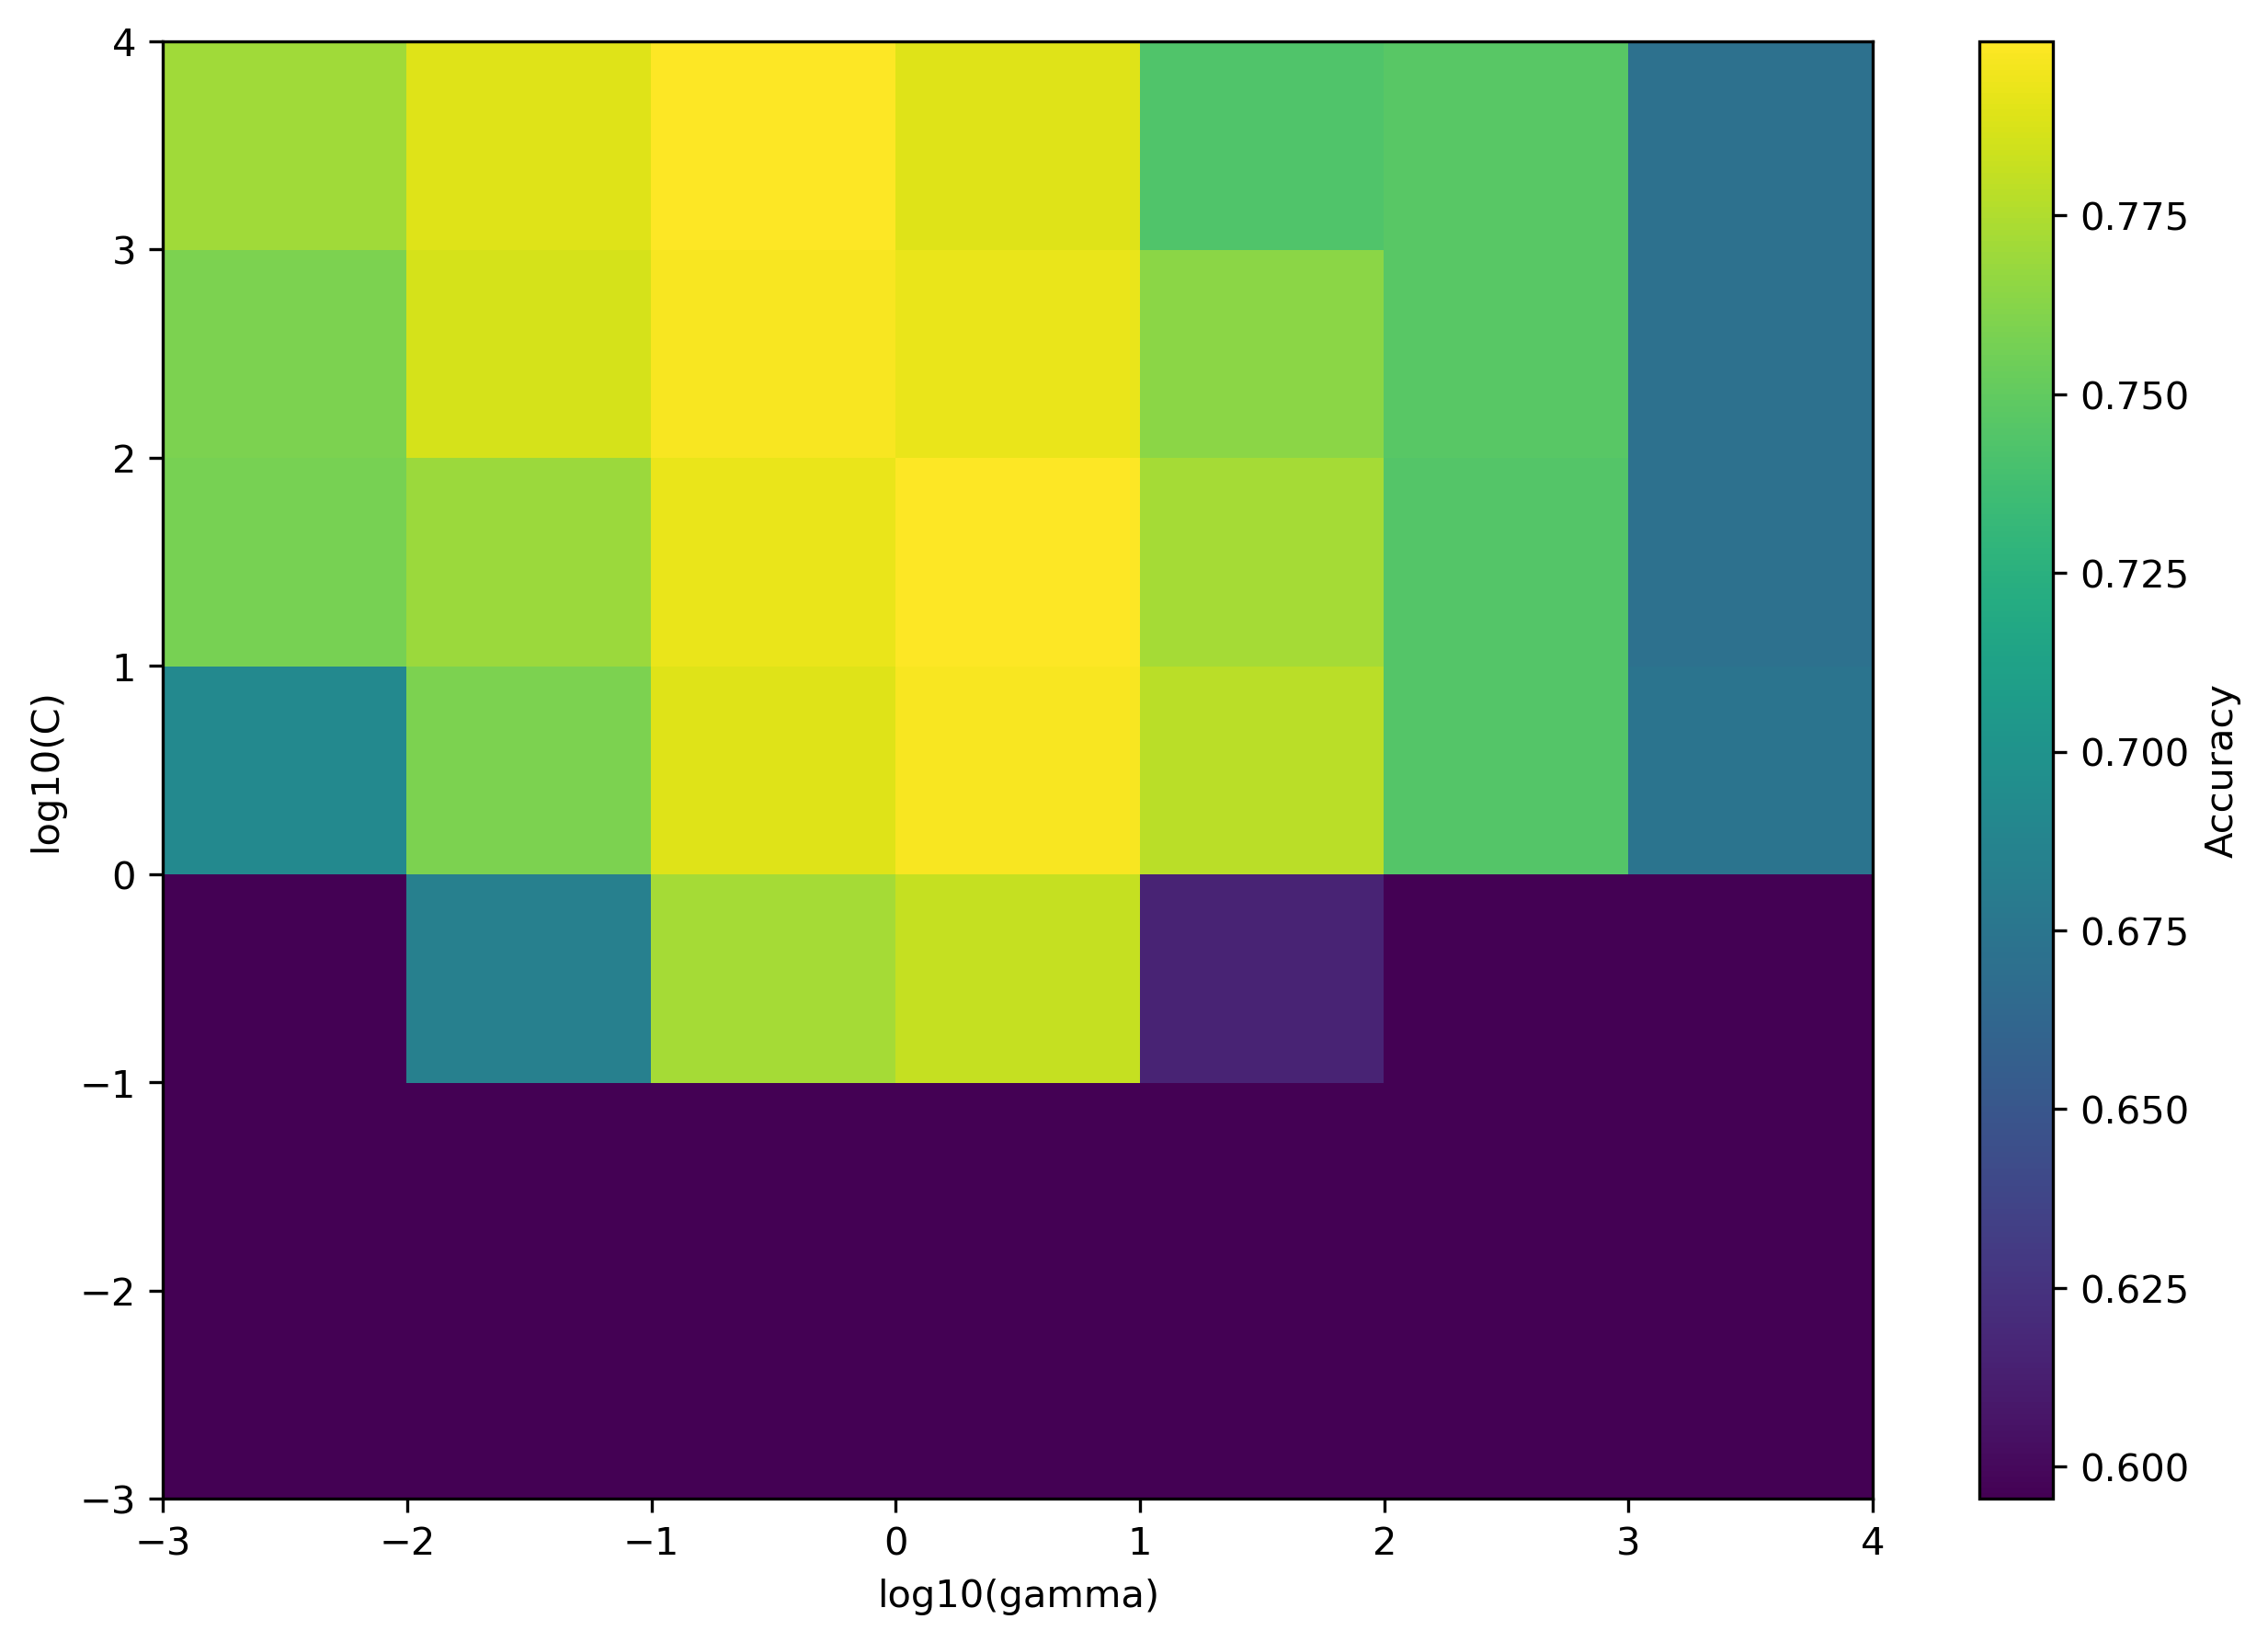

In [18]:
X_plt,y_plt = np.meshgrid(parameters['gamma'],parameters['C'])
plt.pcolor(np.log10(X_plt),np.log10(y_plt),grid.cv_results_['mean_test_score'].reshape(len(parameters['C']),len(parameters['gamma'])))
plt.xlabel('log10(gamma)')
plt.ylabel('log10(C)')
cbar = plt.colorbar()
cbar.set_label('Accuracy')

With SVC we have two major adjustable parameters C and gamma according to https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py i.e. from the scikitlearn documentation for SVC. According to the documentation, the model scales with log10(gamma) and log10(C) so we can use GridSearchCV to plot out esimated model accuracy (on the training set with 5 fold cross validation) to observe how these two parameters influence the accuracy. We see a clear peak in the accuracy, around 80 % with the location dependent on both C and gamma. This is well in agreement with heatmaps given in the documentation so we are on the right track. Also based on the features we have, It would appear that we have an accuracy ceiling without further feature engineering or changing methods.

Using a heatmap here is helpful because we can easily see that the log of C and gamma are indeed important transformations for assessing the choice of hyperparameter and that we have to scale C and gamma together.

Ideally we would want C as small as possible as it is a measure of smoothness of the decision boundary. So with larger C we have a more flexible model and with that higher variance. In this case since we have a narrow and long dataset i.e. n is much larger than p, we can tolerate a more flexible model since increasing n realative to p reduces variance and increases bias.

In [19]:
pipe=make_pipeline(ct,StandardScaler(),selector, SVC(C=1000,gamma=0.1))
pipe.fit(X_train,y_train)
print('Train Accuracy %.2f' % pipe.score(X_train,y_train))
print('Test Accuracy %.2f' % pipe.score(X_test,y_test))

Train Accuracy 0.84
Test Accuracy 0.85


With our model in hand with ~ 84 to 85 % accuracy on the holdout set, this is pretty decent. I don't expected that further parameter tuning with SVC will be particularly useful. Switching ML methods to something like deep learning can likely improve accuracy however at the cost of computational expense.

Conclusions: I was already fairly familiar with the importance of each of the parameters and their influence on the survivability since I participated in a LinkedIn Learning Course where they went through EDA and ML of this data set about a year ago. So the goal for me was to focus on putting together a machine learning model, compare a few methods and do some simple hyperparameter tuning. On future projects, EDA will be more extensive and I want to try using SelectFromModel to determine relative importance of each feature.